In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'

mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.size'] = 12

plt.style.use('tableau-colorblind10')

In [2]:
def read_data(url):
    df_cpu = pd.read_csv(url)
    df = df_cpu.loc[df_cpu[" utilization.gpu [%]"] > 0] #isolating training 
    #print(df.columns)
    return df, df_cpu

In [3]:
def time_duration(df):
    df.timestamp = [datetime.strptime(time, "%Y/%m/%d %H:%M:%S.%f") for time in df.timestamp]
    time_interval = df.iloc[-1].timestamp - df.iloc[0].timestamp
    #print("Total time in seconds: {}".format(time_interval.total_seconds()))
    return time_interval.total_seconds()

In [4]:
def power_reading(url):
    df, df_cpu = read_data(url)
    time_interval = time_duration(df)
    cpu_time_interval = time_duration(df_cpu)
    df_gpu1 = df.iloc[::2]
    df_gpu2 = df.iloc[1::2]
    mean_power = df[' power.draw [W]'].mean() # refer notebook on time series
    total_power = mean_power * time_interval * 2 / (1000 *60*60)
    summed_power = df[' power.draw [W]'].sum() / (1000 *60*60)
    cpu_energy = (85 * cpu_time_interval) / (1000 *60*60)
    gpu1_mean = df_gpu1[' power.draw [W]'].mean()
    gpu2_mean = df_gpu2[' power.draw [W]'].mean()
    gpu1_util = df_gpu1[' utilization.gpu [%]'].mean()
    gpu2_util = df_gpu2[' utilization.gpu [%]'].mean()
    gpu_util = (gpu1_util + gpu2_util) / 2
    memory_util = df[' utilization.memory [%]'].mean()
    memory_used = df[' memory.used [MiB]'].mean()
    extract = url.split('/')[1].replace(".","_").split('_')
    end_time = df_cpu.iloc[-1].timestamp
    start_time = df_cpu.iloc[0].timestamp
    total_energy = cpu_energy + total_power
    data = []
    if (extract[2] != 'pretrain'):
        data = [extract[2], extract[3], 128,
                mean_power,time_interval,total_power,summed_power,gpu_util,
                gpu1_util,gpu2_util,gpu1_mean,gpu2_mean,
                memory_util,memory_used, start_time, end_time, total_energy, cpu_time_interval]
#     else:
#         data = [extract[2], None, None,
#                 mean_power,time_interval,total_power,gpu_util,memory_util,memory_used]
    return df, data

In [5]:
import os
folder_name = 'nvidia_july'
result = pd.DataFrame(columns=['dataset','batchsize','max_seq_len',
                               'mean_power','total_time','power','summed_power','gpu_util',
                               'gpu1_util','gpu2_util','gpu1_mean_power','gpu2_mean_power',
                               'memory_util','memory_used',
                               'start_time','end_time','total_energy', 'cpu_time'])

for file_name in os.listdir(folder_name):
    #print(file_name)
    if(file_name not in ['.DS_Store','nvidia_power_pretrain.csv','nvidia_power_pretrain_11mb.csv']):
        url = folder_name + '/' + file_name
        df,data = power_reading(url)
       # print (data)
        if data:
            result =result.append(pd.Series(data, index=result.columns),ignore_index=True)
    #print ("-------------------------------------------")

/Users/shivangi/Documents/power_monitor/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [6]:
# https://www.tensorflow.org/datasets/catalog/glue
train_dataset_sizes = {
    'MRPC': 3668,
    'CoLA': 8551,
    'SST-2':67349,
    'MNLI': 392702,
    'STS-B':8628,
    'STS-B':5749,
    'QQP':  363846,
    'RTE':  2490,
    'QNLI': 104743,
    'WNLI': 635
}

In [7]:
result['dataset_size'] = result['dataset']
result["dataset_size"].replace(train_dataset_sizes, inplace=True)

In [8]:
result[["batchsize","max_seq_len"]] = result[["batchsize","max_seq_len"]].apply(pd.to_numeric)
result["total_batchsize"] = result["batchsize"] * 2
result["samples_per_sec"] = (result["dataset_size"] * 3) / result.total_time #3 epochs
result["time_per_sample"] = result.total_time /(result["dataset_size"] * 3)
result.head()

,dataset,batchsize,max_seq_len,mean_power,total_time,power,summed_power,gpu_util,gpu1_util,gpu2_util,...,memory_util,memory_used,start_time,end_time,total_energy,cpu_time,dataset_size,total_batchsize,samples_per_sec,time_per_sample
0,QQP,64,128,221.293764,1499.594,0.184362,0.163143,93.430671,93.330821,93.530520,...,38.376790,8485.080256,2020-07-23 18:45:29.614,2020-07-23 19:10:29.208,0.219769,1499.594,363846,128,727.889015,0.001374
1,QQP,64,128,216.107605,2699.915,0.324151,0.289704,93.279735,93.200995,93.358475,...,37.991090,8488.894115,2020-07-23 20:55:29.624,2020-07-23 21:40:29.539,0.387899,2699.915,363846,128,404.286061,0.002473
2,QQP,64,128,228.960790,899.106,0.114367,0.107930,93.758648,94.332155,93.185142,...,38.731291,8482.586329,2020-07-23 18:10:28.875,2020-07-23 18:25:27.981,0.135596,899.106,363846,128,1214.025932,0.000824
3,QQP,32,128,208.419077,7597.159,0.879663,0.854576,92.870424,92.544642,93.196206,...,34.764108,5253.838968,2020-07-23 00:15:15.695,2020-07-23 02:22:07.955,1.059397,7612.260,363846,64,143.677130,0.006960
4,QQP,64,128,217.339979,2099.495,0.253502,0.225309,92.994373,93.243837,92.744909,...,37.803859,8481.640943,2020-07-23 19:40:29.581,2020-07-23 20:15:29.076,0.303074,2099.495,363846,128,519.905025,0.001923


## approx flops using the ai and compute equation
Number of GPUs * (peta-flops/GTX580) * days trained * estimated utilization

In [9]:
gtx1080TFLOPS = 11.34  # https://www.techpowerup.com/gpu-specs/geforce-gtx-1080-ti.c2877
result['TFLOPs'] = 2 * gtx1080TFLOPS *  result['total_time'] * result['gpu_util']
result['PFLOPs'] = result['TFLOPs'] / 1000
result['PFLOPs_per_example'] = result['PFLOPs'] / (result["dataset_size"] * 3)

In [10]:
# #rename file when ready and use that instead of the above steps
# #import time
# result_file = "results/QQP_result_final.csv"
# result.to_csv(result_file, index=False)

In [11]:
result.head()

,dataset,batchsize,max_seq_len,mean_power,total_time,power,summed_power,gpu_util,gpu1_util,gpu2_util,...,end_time,total_energy,cpu_time,dataset_size,total_batchsize,samples_per_sec,time_per_sample,TFLOPs,PFLOPs,PFLOPs_per_example
0,QQP,64,128,221.293764,1499.594,0.184362,0.163143,93.430671,93.330821,93.530520,...,2020-07-23 19:10:29.208,0.219769,1499.594,363846,128,727.889015,0.001374,3.177651e+06,3177.651100,0.002911
1,QQP,64,128,216.107605,2699.915,0.324151,0.289704,93.279735,93.200995,93.358475,...,2020-07-23 21:40:29.539,0.387899,2699.915,363846,128,404.286061,0.002473,5.711898e+06,5711.898014,0.005233
2,QQP,64,128,228.960790,899.106,0.114367,0.107930,93.758648,94.332155,93.185142,...,2020-07-23 18:25:27.981,0.135596,899.106,363846,128,1214.025932,0.000824,1.911900e+06,1911.900490,0.001752
3,QQP,32,128,208.419077,7597.159,0.879663,0.854576,92.870424,92.544642,93.196206,...,2020-07-23 02:22:07.955,1.059397,7612.260,363846,64,143.677130,0.006960,1.600191e+07,16001.905209,0.014660
4,QQP,64,128,217.339979,2099.495,0.253502,0.225309,92.994373,93.243837,92.744909,...,2020-07-23 20:15:29.076,0.303074,2099.495,363846,128,519.905025,0.001923,4.428071e+06,4428.070895,0.004057


## get power monitor readings

In [12]:
df_reading = pd.read_csv("results/new-QQP-pm.csv")

In [13]:
df_reading['last_changed'] = pd.to_datetime(df_reading['last_changed'], errors='coerce')
df_reading.dropna(subset=['last_changed'], inplace=True)
df_reading.set_index('last_changed', inplace=True)

In [14]:
df_time_interval = pd.read_csv("results/QQP_result_final.csv")

In [15]:
df_time_interval['start_seconds']= [datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S.%f") - timedelta(hours=1, minutes=0)
                                  for start_time in df_time_interval.start_time]
df_time_interval['end_seconds'] = [datetime.strptime(end_time, "%Y-%m-%d %H:%M:%S.%f") - timedelta(hours=1, minutes=0)
                                for end_time in df_time_interval.end_time]
df_time_interval.head()

,dataset,batchsize,max_seq_len,mean_power,total_time,power,summed_power,gpu_util,gpu1_util,gpu2_util,...,cpu_time,dataset_size,total_batchsize,samples_per_sec,time_per_sample,TFLOPs,PFLOPs,PFLOPs_per_example,start_seconds,end_seconds
0,QQP,64,128,221.293764,1499.594,0.184362,0.163143,93.430671,93.330821,93.530520,...,1499.594,363846,128,727.889015,0.001374,3.177651e+06,3177.651100,0.002911,2020-07-23 17:45:29.614,2020-07-23 18:10:29.208
1,QQP,64,128,216.107605,2699.915,0.324151,0.289704,93.279735,93.200995,93.358475,...,2699.915,363846,128,404.286061,0.002473,5.711898e+06,5711.898014,0.005233,2020-07-23 19:55:29.624,2020-07-23 20:40:29.539
2,QQP,64,128,228.960790,899.106,0.114367,0.107930,93.758648,94.332155,93.185142,...,899.106,363846,128,1214.025932,0.000824,1.911900e+06,1911.900490,0.001752,2020-07-23 17:10:28.875,2020-07-23 17:25:27.981
3,QQP,32,128,208.419077,7597.159,0.879663,0.854576,92.870424,92.544642,93.196206,...,7612.260,363846,64,143.677130,0.006960,1.600191e+07,16001.905209,0.014660,2020-07-22 23:15:15.695,2020-07-23 01:22:07.955
4,QQP,64,128,217.339979,2099.495,0.253502,0.225309,92.994373,93.243837,92.744909,...,2099.495,363846,128,519.905025,0.001923,4.428071e+06,4428.070895,0.004057,2020-07-23 18:40:29.581,2020-07-23 19:15:29.076


In [16]:
df_time_interval['s_date'] = [x.date().strftime("%Y-%m-%d") for x in df_time_interval["start_seconds"]]
df_time_interval['e_date'] = [x.date().strftime("%Y-%m-%d") for x in df_time_interval["end_seconds"]]
df_time_interval['s_time'] = [x.time().strftime("%H:%M:%S") for x in df_time_interval["start_seconds"]]
df_time_interval['e_time'] = [x.time().strftime("%H:%M:%S") for x in df_time_interval["end_seconds"]]

In [17]:
def power_mean(s_date,e_date,s_time,e_time):
    subset_df = df_reading.loc[s_date:e_date].between_time(s_time, e_time)[['power_consumption']]
    return subset_df['power_consumption'].mean()

In [18]:
def energy_consumption(s_date,e_date,s_time,e_time):
    subset_df = df_reading.loc[s_date:e_date].between_time(s_time, e_time)[['power_consumption']]
    return ((subset_df['power_consumption']).sum() * 3) / (1000 * 3600)

In [19]:
for index, row in df_time_interval.iterrows(): 
    df_time_interval.at[index,'pm_mean_power'] = power_mean(row['s_date'],row['e_date'],
                                            row['s_time'],row['e_time'])

In [20]:
df_time_interval['pm_power'] = (df_time_interval['pm_mean_power'] * df_time_interval['total_time']) / (1000 * 3600)


In [21]:
for index, row in df_time_interval.iterrows(): 
    df_time_interval.at[index,'pm_energy_consumption'] = energy_consumption(row['s_date'],row['e_date'],
                                            row['s_time'],row['e_time'])

In [22]:
df_co2 = pd.read_csv("results/co2data.csv")
df_co2.head()

,provider,providerName,offsetRatio,region,regionName,country,state,city,impact,source,comment,country_code,continent,continent_name
0,gcp,Google Cloud Platform,100,asia-east1,NaN,Taiwan,NaN,Changhua County,557.0,"measured on July 2, 2019 between 8 and 9 PM, ...",NaN,TW,AS,Asia
1,gcp,Google Cloud Platform,100,asia-east2,NaN,China,NaN,Hong Kong,702.0,https://www.sciencedirect.com/science/article/...,NaN,CN,AS,Asia
2,gcp,Google Cloud Platform,100,asia-northeast1,NaN,Japan,NaN,Tokyo,516.0,https://www.sciencedirect.com/science/article/...,NaN,JP,AS,Asia
3,gcp,Google Cloud Platform,100,asia-northeast2,NaN,Japan,NaN,Osaka,516.0,https://www.fepc.or.jp/library/pamphlet/pdf/04...,NaN,JP,AS,Asia
4,gcp,Google Cloud Platform,100,asia-south1,NaN,India,NaN,Mumbai,920.0,https://www.fepc.or.jp/library/pamphlet/pdf/04...,NaN,IN,AS,Asia


In [23]:
uk_co2 = df_co2.loc[df_co2.country == 'United Kingdom'].impact.mean()

In [24]:
df_time_interval = df_time_interval.sort_values('dataset_size')
df_time_interval['CO2e'] = uk_co2 * df_time_interval['pm_energy_consumption']
df_time_interval['kg CO2e/kWh'] = df_time_interval['CO2e'] /1000
df_time_interval["time_in_hour"] = df_time_interval["total_time"] / 3600

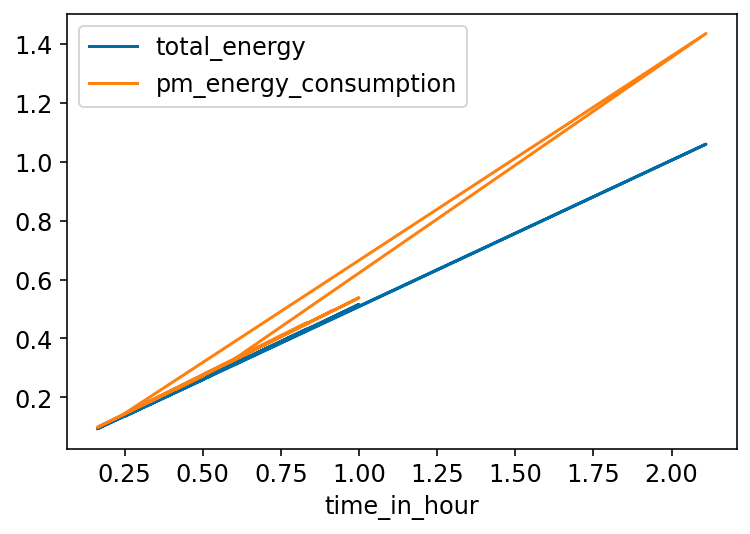

In [25]:
df_time_interval.plot(x='time_in_hour', y=['total_energy','pm_energy_consumption'])

In [26]:
# appends to existing data from may-june

df_time_interval.to_csv("results/model_pm_energy_finetune.csv",mode='a', header=False, index=False)